# GIF GENERATION


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from PIL import Image
import PIL
from matplotlib.pyplot import imsave
from matplotlib.pyplot import cm
import io
import imageio

In [3]:
class RBFInterpolation:
    def __init__(self,pointList,pointValues):
        self.pointListSize = 4
        self.pointList = pointList
        #w coefficients
        self.w = np.zeros(self.pointListSize)
        #distance matrix
        self.rbf = np.zeros((self.pointListSize,self.pointListSize))
        #compute the distance matrix
        for i in range(self.pointListSize):
            for j in range(self.pointListSize):
                self.rbf[i][j] = rbfDistance(pointList[i],pointList[j])
        
        # compute the w coefficients (solve linear system Ax=b)
        for i in range(self.pointListSize):
            self.w = np.linalg.solve(self.rbf,pointValues)

    
    def  interpolation(self,point):
        value = 0
        for i in range(self.pointListSize):
            value += self.w[i] * rbfDistance(point,self.pointList[i]);  
        return value

def rbfDistance(pt1,pt2):
    def getNorm(vec):
        d = np.sqrt(vec[0]**2 + vec[1]**2)
        return d
    d = getNorm(pt1-pt2)
    return np.exp(-0.0001 *d*d)


In [6]:
def make_n_gif(nb_gif_you_want):

    for t in range(nb_gif_you_want):
        image_size = 128
        input_dim = 100
        nb_points = 4

    # generate points in latent space as input for the generator
        def generate_latent_points(latent_dim, n_samples):
            # generate points in the latent space
            x_input = randn(latent_dim * n_samples)
            # reshape into a batch of inputs for the network
            z_input = x_input.reshape(n_samples, latent_dim)
            return z_input
    # create a plot of generated images
        def plot_generated(examples, n):
            # plot images
            for i in range(n):
                # define subplot
                pyplot.subplot(1, n, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                img= np.zeros((image_size,image_size))
                for j in range(image_size):
                    for k in range(image_size):
                        img[j,k] = examples[i,j,k,0]

                return img



        # load model
        model = load_model('generator.h5')

        # generate 4 points in latent space
        pt1 = generate_latent_points(input_dim, 1)
        pt2 = generate_latent_points(input_dim, 1)
        pt3 = generate_latent_points(input_dim, 1)
        pt4 = generate_latent_points(input_dim, 1)
                
        latentspace2D = np.zeros((image_size,image_size,input_dim))

        pointListPos = np.zeros((nb_points,2))
        pointListseed = np.zeros((input_dim,nb_points))

        print(pt1.shape)
        for i in range(input_dim):
                pointListseed[i,0] = pt1[0,i]
                pointListseed[i,1] = pt2[0,i]
                pointListseed[i,2] = pt3[0,i]
                pointListseed[i,3] = pt4[0,i]


        pt = np.zeros(2)
        compteur = 0
        pt[0] = 0
        pt[1] = 0
        pointListPos[compteur] = pt; 
        for i in range(input_dim):
            latentspace2D[int(pt[0]),int(pt[1]),i] = pointListseed[i,compteur]

        compteur+=1

        pt[0] = 0
        pt[1] = image_size-1
        pointListPos[compteur] = pt
        for i in range(input_dim):
            latentspace2D[int(pt[0]),int(pt[1]),i] = pointListseed[i,compteur]

        compteur+=1

        pt[0] = image_size-1
        pt[1] = 0
        pointListPos[compteur] = pt
        for i in range(input_dim):
            latentspace2D[int(pt[0]),int(pt[1]),i] = pointListseed[i,compteur]

        compteur+=1

        pt[0] = image_size-1
        pt[1] = image_size-1
        pointListPos[compteur] = pt
        for i in range(input_dim):
            latentspace2D[int(pt[0]),int(pt[1]),i] = pointListseed[i,compteur]

        rbf_tab = []
        for i in range(input_dim):
            rbf_par = RBFInterpolation(pointListPos,pointListseed[i]) 
            rbf_tab.append(rbf_par)

        for i in range(image_size):
            for j in range(image_size):
                pt[0] = i
                pt[1] = j
                for k in range(input_dim):
                    latentspace2D[i,j,k] = min(max(rbf_tab[k].interpolation(pt),-2.5),2.5)
        plt.figure()    

        def dessine_stp(x,y,compte):
            ptgenerated = np.zeros((1,input_dim))
            for i in range(input_dim):
                ptgenerated[0,i] = latentspace2D[x,y,i]
            img_gene = model.predict(ptgenerated)
            img = plot_generated(img_gene, len(ptgenerated))

            imsave("images_gif/image_%d.png" % compte, img)
            Image.open("images_gif/image_%d.png" % compte).convert('L').save("images_gif/imageg_%d.png" % compte)
        
        def autoplay (iterations,size):
            num_image = 0
            for i in range (iterations):
                angle =  (2 * np.pi)*i / iterations
                x = int(((np.cos(angle)*size/2) + size/2))
                y = int(((np.sin(angle)*size/2) + size/2))
                if(x>127):
                    x=127
                if(y>127):
                    y=127
                dessine_stp(x,y,num_image)
                num_image +=1
            for i in range(iterations):
                x = int(-i/iterations*size +size)
                y = int(i/iterations*size)
                if(x>127):
                    x=127
                if(y>127):
                    y=127
                dessine_stp(x,y,num_image)
                num_image +=1 
            for i in range(iterations):
                y = int(-i/iterations*size +size)
                if(x>127):
                    x=127
                if(y>127):
                    y=127
                dessine_stp(x,y,num_image)
                num_image +=1
            for i in range(iterations):
                x = int(i/iterations*size)
                y = int(i/iterations*size)
                if(x>127):
                    x=127
                if(y>127):
                    y=127
                dessine_stp(x,y,num_image)
                num_image +=1

        autoplay(300,image_size)
        
        with imageio.get_writer('gifs/gif_%d.gif' % t, mode='I') as writer:
            for i in range (1200):
                image = imageio.imread('images_gif/imageg_'+ str(i) + '.png')
                writer.append_data(image)
        
        print(t,'/100')

(1, 100)


C:\Users\valen\.conda\envs\gan\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0 /100
(1, 100)
1 /100
(1, 100)
2 /100
(1, 100)
3 /100
(1, 100)
4 /100
(1, 100)
5 /100
(1, 100)
6 /100
(1, 100)
7 /100
(1, 100)
8 /100
(1, 100)
9 /100
(1, 100)
10 /100
(1, 100)
11 /100
(1, 100)
12 /100
(1, 100)
13 /100
(1, 100)
14 /100
(1, 100)
15 /100
(1, 100)
16 /100
(1, 100)
17 /100
(1, 100)
18 /100
(1, 100)
19 /100


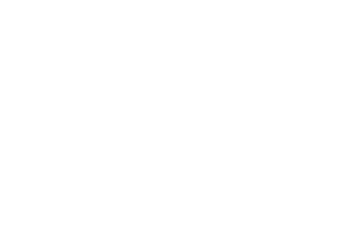

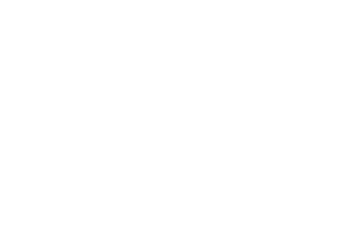

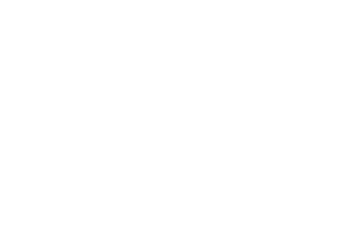

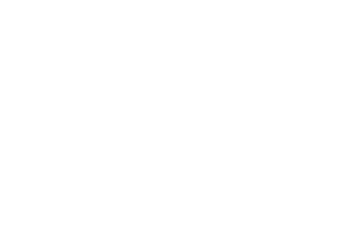

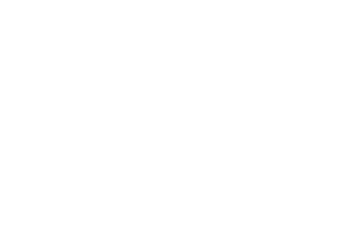

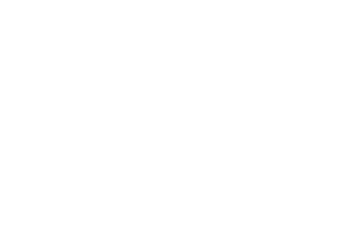

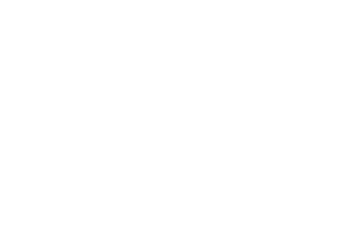

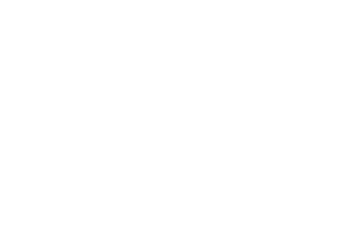

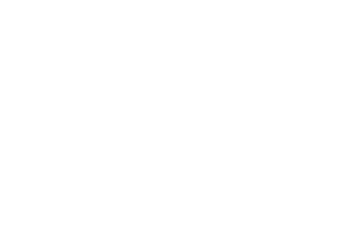

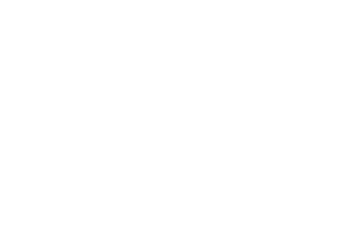

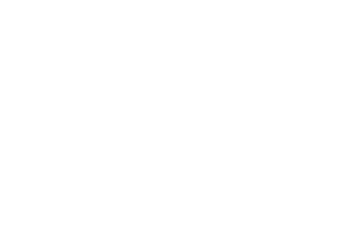

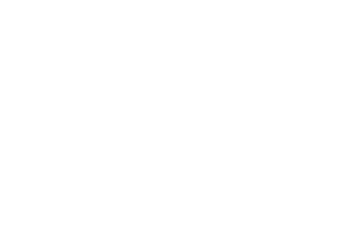

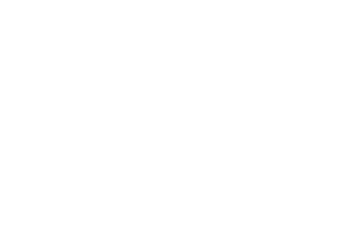

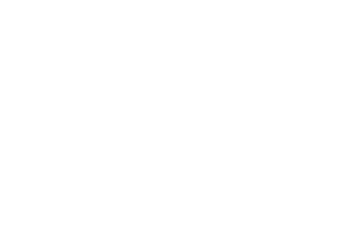

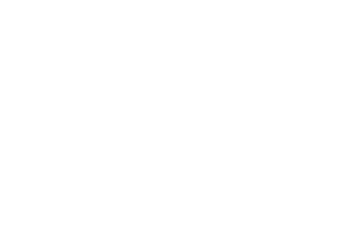

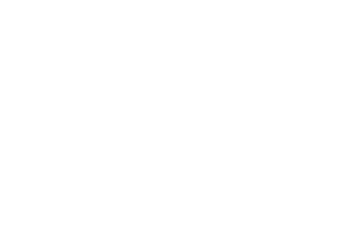

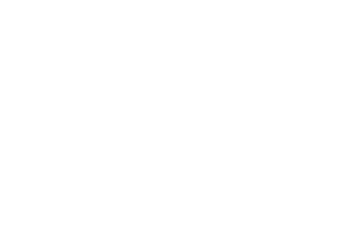

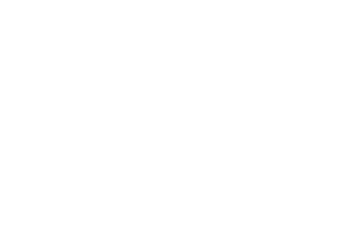

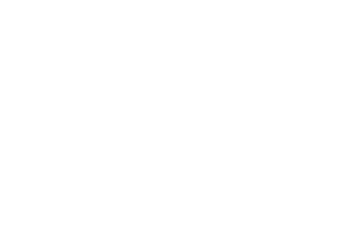

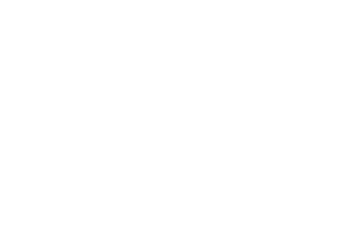

In [8]:
make_n_gif(20)